In [70]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

#regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statistics import *
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#clustering
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics

!pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf




In [71]:
prec = pd.read_csv('precipitacionsbarcelonadesde1786.csv')
prec.head()

,Any,Precip_Acum_Gener,Precip_Acum_Febrer,Precip_Acum_Marc,Precip_Acum_Abril,Precip_Acum_Maig,Precip_Acum_Juny,Precip_Acum_Juliol,Precip_Acum_Agost,Precip_Acum_Setembre,Precip_Acum_Octubre,Precip_Acum_Novembre,Precip_Acum_Desembre
0,1786,32.8,28.4,84.4,42.3,8.5,38.0,6.8,52.1,62.0,57.0,195.8,114.1
1,1787,136.4,27.4,44.6,76.9,0.0,29.8,34.7,14.9,205.8,12.4,42.2,0.0
2,1788,9.9,14.9,32.2,12.4,7.5,146.3,59.4,29.8,123.9,163.6,106.6,22.3
3,1789,12.4,12.4,23.6,9.9,32.2,9.9,6.3,69.4,18.7,52.1,18.7,76.9
4,1790,44.6,1.2,188.5,74.4,44.7,39.7,65.7,32.3,71.9,205.8,72.0,14.9


In [72]:
#rename columns
prec.rename(columns={'Precip_Acum_Gener': "1",
                   'Precip_Acum_Febrer': "2",
                   'Precip_Acum_Marc': "3",
                   'Precip_Acum_Abril': "4",
                   'Precip_Acum_Maig': "5",
                   'Precip_Acum_Juny': "6",
                   'Precip_Acum_Juliol': "7",
                   'Precip_Acum_Agost': "8",
                   'Precip_Acum_Setembre': "9",
                   'Precip_Acum_Octubre': "10",
                   'Precip_Acum_Novembre': "11",
                   'Precip_Acum_Desembre': "12"},inplace=True)

In [73]:
prec.columns

Index(['Any', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

<AxesSubplot:xlabel='Any'>

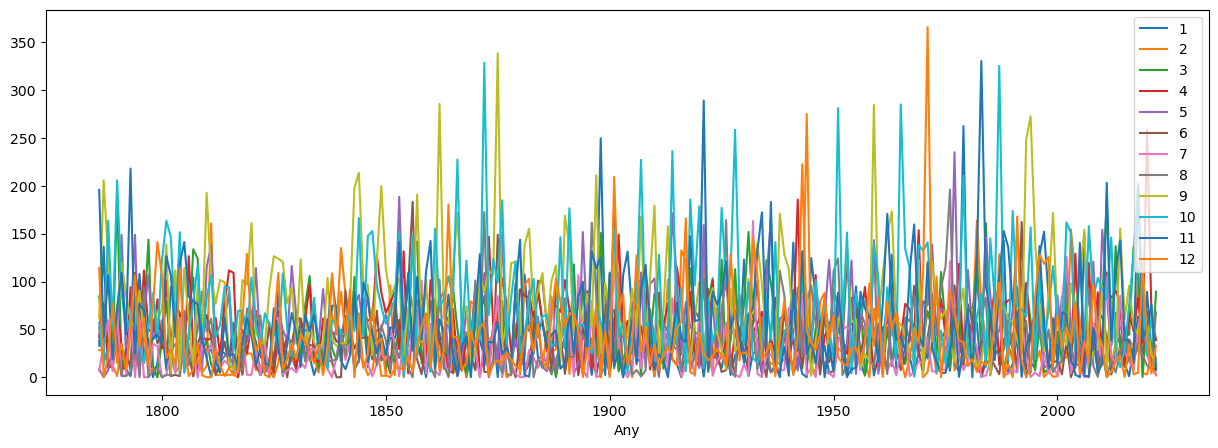

In [74]:
prec.plot(x= 'Any',figsize=(15, 5))

In [75]:
years = prec['Any'].unique()
df = pd.DataFrame(years, columns = ['Any'])
df['id'] = prec.index + 1
df.head(2)

,Any,id
0,1786,1
1,1787,2


In [76]:
df = prec.merge(df, how='left',on='Any')

In [77]:
df

,Any,1,2,3,4,5,6,7,8,9,10,11,12,id
0,1786,32.8,28.4,84.4,42.3,8.5,38.0,6.8,52.1,62.0,57.0,195.8,114.1,1
1,1787,136.4,27.4,44.6,76.9,0.0,29.8,34.7,14.9,205.8,12.4,42.2,0.0,2
2,1788,9.9,14.9,32.2,12.4,7.5,146.3,59.4,29.8,123.9,163.6,106.6,22.3,3
3,1789,12.4,12.4,23.6,9.9,32.2,9.9,6.3,69.4,18.7,52.1,18.7,76.9,4
4,1790,44.6,1.2,188.5,74.4,44.7,39.7,65.7,32.3,71.9,205.8,72.0,14.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2018,63.6,104.6,112.5,83.0,30.3,53.1,51.5,36.5,44.4,201.9,201.8,4.8,233
233,2019,18.2,4.6,0.3,36.2,109.0,19.3,75.8,23.1,71.5,83.2,39.4,119.2,234
234,2020,89.3,2.8,61.6,258.7,29.2,69.1,23.1,12.4,60.2,23.1,52.5,41.5,235
235,2021,26.2,26.5,7.7,62.7,13.4,7.8,9.0,8.3,23.3,63.2,75.9,3.8,236


<AxesSubplot:xlabel='Any'>

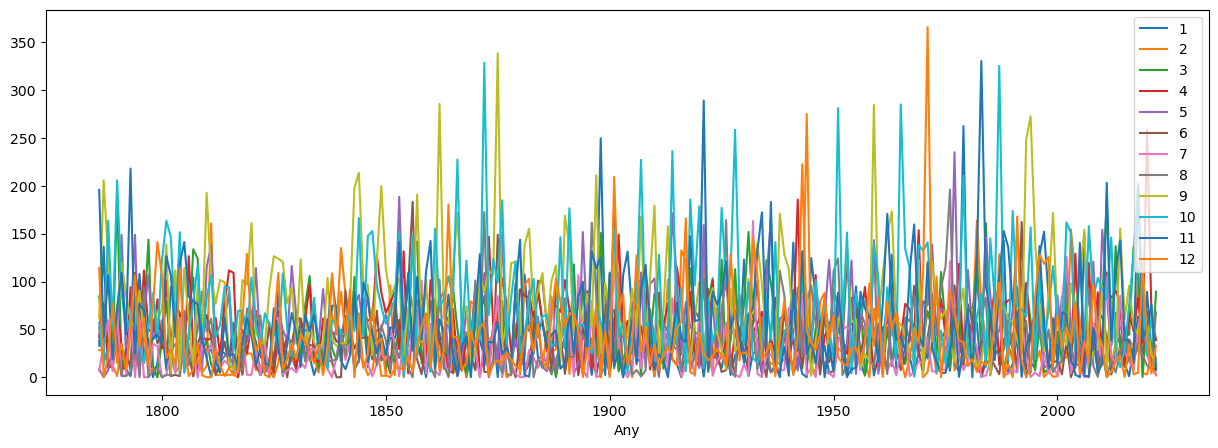

In [78]:
prec.plot(x= 'Any',figsize=(15, 5))

In [79]:
# Creates a pivot table dataframe
table = df.melt(id_vars=['Any', 'id'], value_vars=['1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12'])


In [80]:
table.rename(columns = {'value': "Total_precipitació"})

,Any,id,variable,Total_precipitació
0,1786,1,1,32.8
1,1787,2,1,136.4
2,1788,3,1,9.9
3,1789,4,1,12.4
4,1790,5,1,44.6
...,...,...,...,...
2839,2018,233,12,4.8
2840,2019,234,12,119.2
2841,2020,235,12,41.5
2842,2021,236,12,3.8


In [81]:
prom = table.groupby(['Any','variable']).mean()
prom

id  value
Any  variable              
1786 1           1.0   32.8
     10          1.0   57.0
     11          1.0  195.8
     12          1.0  114.1
     2           1.0   28.4
...              ...    ...
2022 5         237.0   20.0
     6         237.0    9.5
     7         237.0    2.7
     8         237.0   67.9
     9         237.0   13.1

[2844 rows x 2 columns]

<AxesSubplot:xlabel='Any', ylabel='value'>

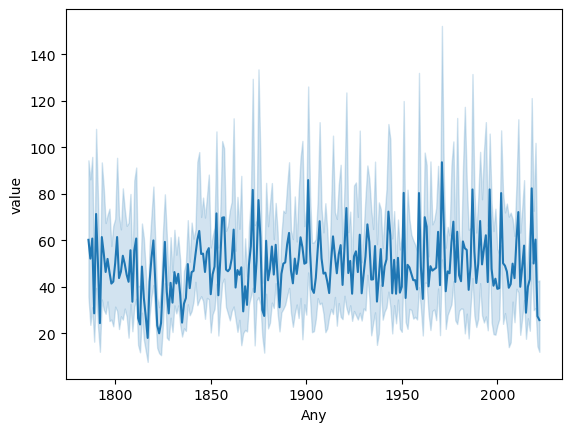

In [82]:
sns.lineplot(data=prom, x='Any', y='value')


In [83]:
temp = pd.read_csv('temperaturesbarcelonadesde1780.csv')
temp.head()

,Any,Temp_Mitjana_Gener,Temp_Mitjana_Febrer,Temp_Mitjana_Marc,Temp_Mitjana_Abril,Temp_Mitjana_Maig,Temp_Mitjana_Juny,Temp_Mitjana_Juliol,Temp_Mitjana_Agost,Temp_Mitjana_Setembre,Temp_Mitjana_Octubre,Temp_Mitjana_Novembre,Temp_Mitjana_Desembre
0,1786,7.8,8.3,9.9,12.8,16.8,20.2,20.9,21.1,19.5,15.5,9.2,8.3
1,1787,5.4,7.8,11.3,12.1,14.7,19.2,21.0,21.8,19.4,15.5,9.3,10.8
2,1788,6.4,10.1,10.4,12.5,17.1,19.2,22.1,23.0,19.1,15.5,10.5,5.4
3,1789,6.9,9.3,8.7,13.3,17.7,18.5,20.9,21.9,20.0,14.7,7.8,7.3
4,1790,7.4,9.5,10.4,12.3,15.0,19.0,20.8,23.1,19.3,17.1,11.7,7.9


In [84]:
#rename columns
temp.rename(columns={'Temp_Mitjana_Gener': "1",
                   'Temp_Mitjana_Febrer': "2",
                   'Temp_Mitjana_Marc': "3",
                   'Temp_Mitjana_Abril': "4",
                   'Temp_Mitjana_Maig': "5",
                   'Temp_Mitjana_Juny': "6",
                   'Temp_Mitjana_Juliol': "7",
                   'Temp_Mitjana_Agost': "8",
                   'Temp_Mitjana_Setembre': "9",
                   'Temp_Mitjana_Octubre': "10",
                   'Temp_Mitjana_Novembre': "11",
                   'Temp_Mitjana_Desembre': "12"},inplace=True)

In [85]:
years = temp['Any'].unique()
df = pd.DataFrame(years, columns = ['Any'])
df['id'] = prec.index + 1
df.head(2)

,Any,id
0,1786,1
1,1787,2


In [86]:
df1 = temp.merge(df, how='left',on='Any')
df

,Any,id
0,1786,1
1,1787,2
2,1788,3
3,1789,4
4,1790,5
...,...,...
232,2018,233
233,2019,234
234,2020,235
235,2021,236


In [87]:
# Creates a pivot table dataframe
table1 = df1.melt(id_vars=['Any','id'], value_vars=['1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12'])

In [88]:
table1.rename(columns = {'value': "Total_temperatures"})

,Any,id,variable,Total_temperatures
0,1786,1,1,7.8
1,1787,2,1,5.4
2,1788,3,1,6.4
3,1789,4,1,6.9
4,1790,5,1,7.4
...,...,...,...,...
2839,2018,233,12,11.1
2840,2019,234,12,11.2
2841,2020,235,12,9.3
2842,2021,236,12,10.9


In [90]:
data = pd.merge(table1, table, on= ('id', 'variable', 'Any'), how='outer')
data.head()

,Any,id,variable,value_x,value_y
0,1786,1,1,7.8,32.8
1,1787,2,1,5.4,136.4
2,1788,3,1,6.4,9.9
3,1789,4,1,6.9,12.4
4,1790,5,1,7.4,44.6


In [91]:
df_def = data.rename(columns={'value_x': "Temperatures", 'value_y':"Precipitacions", 'variable': "Mes"})

In [92]:
df_def.columns

Index(['Any', 'id', 'Mes', 'Temperatures', 'Precipitacions'], dtype='object')

In [93]:
print(f'Número de filas con missing values: {df_def.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [94]:
df_def.dtypes

Any                 int64
id                  int64
Mes                object
Temperatures      float64
Precipitacions    float64
dtype: object

In [95]:
df_def['Mes'] = df_def['Mes'].astype('int64')

In [105]:
df_def.sort_values(by='Temperatures',ascending=False)[['Any','Mes','Temperatures']].head(10)

,Any,Mes,Temperatures
1876,2003,8,28.5
1895,2022,8,27.2
1642,2006,7,27.1
1658,2022,7,26.7
1757,1884,8,26.4
1882,2009,8,26.3
1639,2003,7,26.1
1885,2012,8,26.0
1651,2015,7,26.0
1630,1994,7,25.9


In [106]:
df_def.sort_values(by='Precipitacions',ascending=False)[['Any','Mes','Precipitacions']].head(10)

,Any,Mes,Precipitacions
2792,1971,12,365.8
1985,1875,9,338.5
2567,1983,11,330.4
2219,1872,10,328.6
2334,1987,10,325.4
2505,1921,11,289.2
1972,1862,9,285.6
2312,1965,10,285.1
2069,1959,9,284.5
2298,1951,10,281.1


In [98]:
total = df_def.groupby(['Any']).mean()
total


,id,Mes,Temperatures,Precipitacions
Any,,,,
1786,1.0,6.5,14.191667,60.183333
1787,2.0,6.5,14.025000,52.091667
1788,3.0,6.5,14.275000,60.733333
1789,4.0,6.5,13.916667,28.541667
1790,5.0,6.5,14.458333,71.308333
...,...,...,...,...
2018,233.0,6.5,16.283333,82.333333
2019,234.0,6.5,16.525000,49.983333
2020,235.0,6.5,16.758333,60.291667


<AxesSubplot:xlabel='Any'>

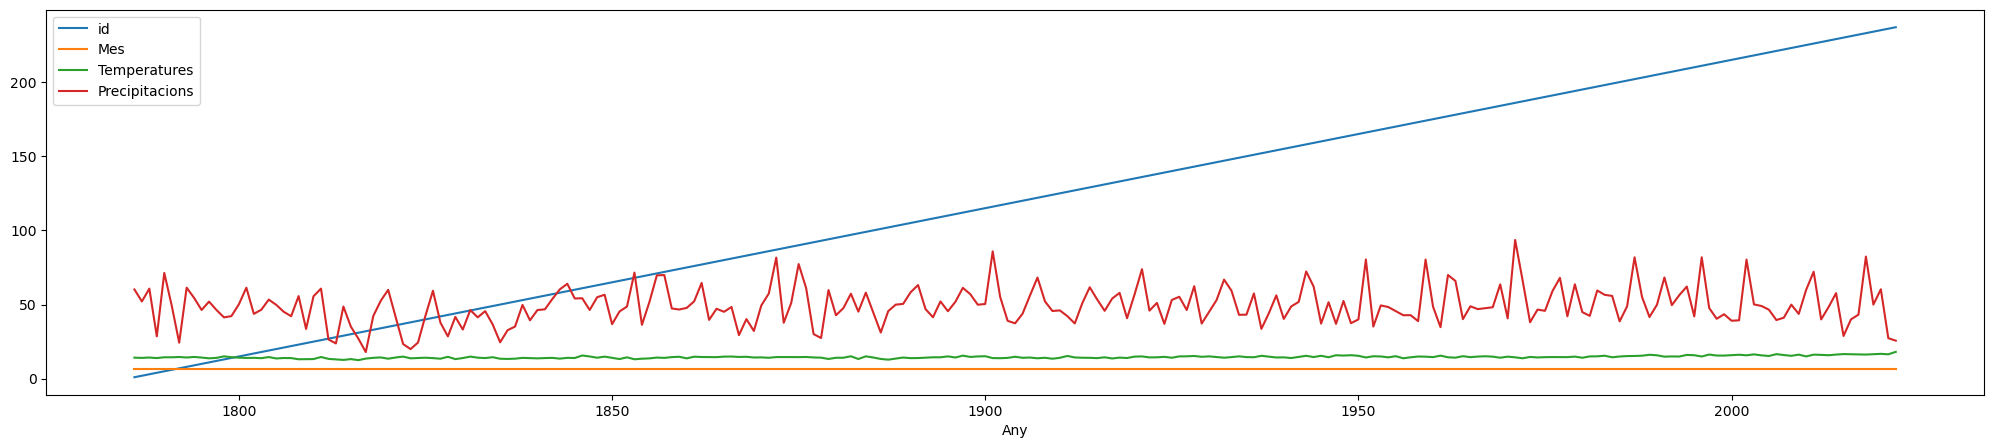

In [99]:
total.plot(figsize=(25,5))

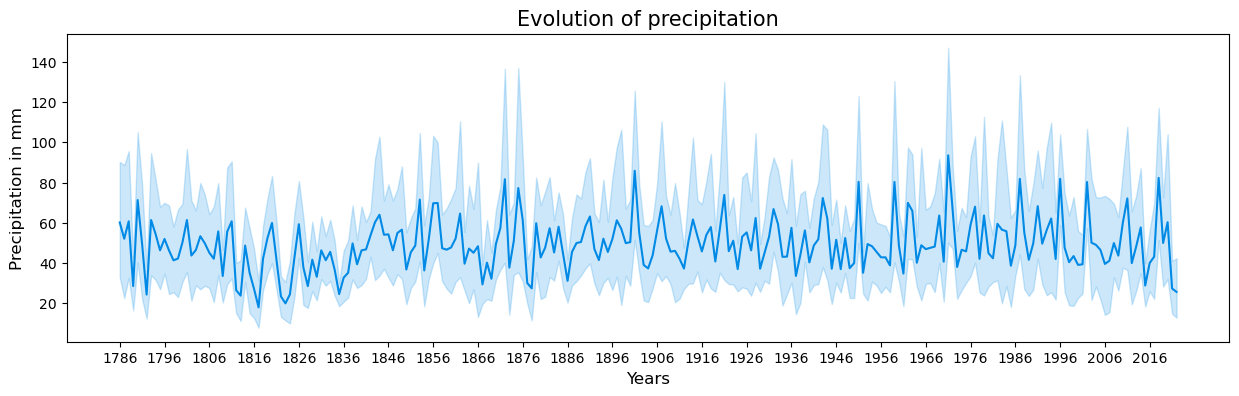

In [109]:
plt.figure(figsize =(15, 4))
sns.lineplot(x=df_def['Any'],y=df_def['Precipitacions'], color='#008ae6')
x = df['Any'].unique()
plt.xticks(np.arange(1786, max(x), 10))

plt.title("Evolution of precipitation",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

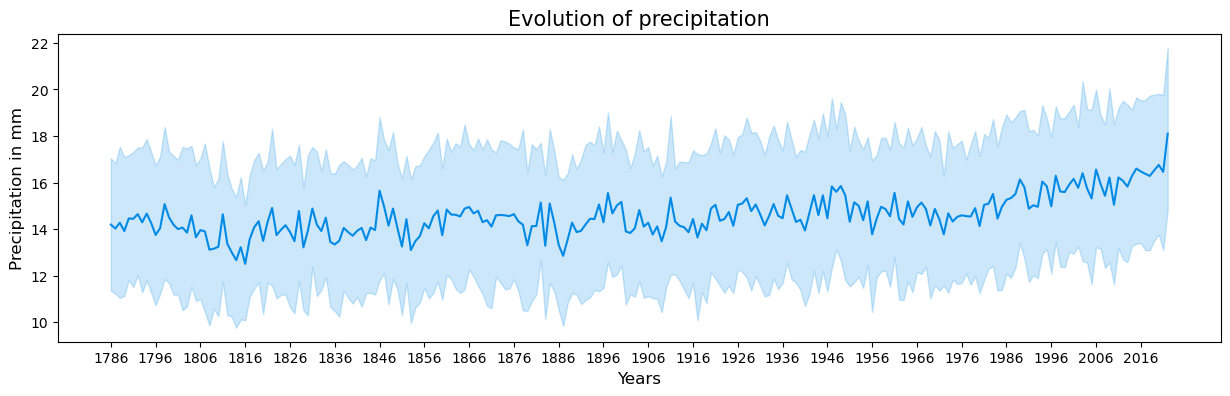

In [110]:
plt.figure(figsize =(15, 4))
sns.lineplot(x=df_def['Any'],y=df_def['Temperatures'], color='#008ae6')
x = df['Any'].unique()
plt.xticks(np.arange(1786, max(x), 10))

plt.title("Evolution of precipitation",fontsize=15)
plt.xlabel("Years",fontsize=12)
plt.ylabel("Precipitation in mm",fontsize=12)
plt.show()

In [100]:
from statsmodels.tsa.stattools import adfuller

In [101]:
stats.normaltest(total["Temperatures"])

<IPython.core.display.Javascript object>

NormaltestResult(statistic=17.534195603685593, pvalue=0.00015577501521784614)

In [102]:
adfuller_results = adfuller(total["Temperatures"])
print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')

ADF Statistic: -0.3480791502246142
p-value: 0.9184134654306413
